In [2]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
import pandas as pd
import numpy as np
np.random.seed(0)
from sklearn.model_selection import GridSearchCV, StratifiedKFold  # , cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix  # , classification_report
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from scipy import integrate
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support,make_scorer
from sklearn.metrics import confusion_matrix

In [3]:
DATA_PATH = '../data/features/'

tran = pd.read_csv(DATA_PATH + "T.csv")
tran = tran.set_index(['ID', 'copy_num'])

ntran = pd.read_csv(DATA_PATH + "NT.csv")
ntran = ntran.set_index(['ID', 'copy_num'])


In [5]:
print("Total amout of obects (oversampled):     {}".format(tran.shape[0]+ntran.shape[0]))
print("Total amout of obects (not oversampled): {}".format(tran[tran.index.get_level_values("copy_num")==0].shape[0]+ntran.shape[0]))

Total amout of obects (oversampled):     62152
Total amout of obects (not oversampled): 19462


In [24]:
feats = np.array(tran.columns[:-4])
print("Total number of features: {}".format(len(feats)))
print()
print("The features are:")
for i,f in enumerate(feats):
    print("    "+str(i+1)+". " + f)


Total number of features: 30

The features are:
    1. skew
    2. std
    3. kurtosis
    4. beyond1st
    5. stetson_j
    6. stetson_k
    7. max_slope
    8. amplitude
    9. median_absolute_deviation
    10. median_buffer_range_percentage
    11. pair_slope_trend
    12. percent_amplitude
    13. percent_difference_flux_percentile
    14. flux_percentile_ratio_mid20
    15. flux_percentile_ratio_mid35
    16. flux_percentile_ratio_mid50
    17. flux_percentile_ratio_mid65
    18. flux_percentile_ratio_mid80
    19. small_kurtosis
    20. pair_slope_trend_last_30
    21. poly1_t1
    22. poly2_t2
    23. poly2_t1
    24. poly3_t3
    25. poly3_t2
    26. poly3_t1
    27. poly4_t4
    28. poly4_t3
    29. poly4_t2
    30. poly4_t1


In [25]:
alldf = pd.concat([tran,ntran])

# Binary Classification 
Transients and non-transients 

In [26]:
def splitTrainTest(dataframe):
    #create output dataframes
    test = pd.DataFrame(columns = ["ID","copy_num"]+list(dataframe.columns))
    test = test.set_index(["ID","copy_num"])

    train = pd.DataFrame(columns = ["ID","copy_num"]+list(dataframe.columns))
    train = train.set_index(["ID","copy_num"])
    
    for uClass in dataframe.Class.unique():
        #get each class 
        classDf = dataframe[dataframe.Class == uClass]
        
        #unique ids
        ids = classDf.index.get_level_values('ID').unique()

        # randomly choose 25% of indices 

        testInd = np.random.choice(ids, int(0.25*len(ids)),replace=False)

        #get dataframes
        test = pd.concat([test,classDf[classDf.index.get_level_values('ID').isin(testInd)]])
        
        train = pd.concat([train,classDf[~classDf.index.get_level_values('ID').isin(testInd)]])

    return train,test


In [27]:
def balance(df):
    #start min at infinity 
    minNum = np.inf
    
    #find the class with the minimum amount of candidates
    for classElem in df.Class.unique():
        numElems = len(df[df.Class==classElem])
        if(numElems<minNum):
            minNum=numElems
    
    #create output dataframe
    ans = pd.DataFrame(columns = ["ID","copy_num"]+list(df.columns))
    ans = ans.set_index(["ID","copy_num"])
    
    #get a sample from all the classes 
    for classElem in df.Class.unique():
        ans = pd.concat([ans,df[df.Class==classElem].sample(n=minNum)])
        
    return ans

In [28]:
#hypermarameters that gridsearch will optimize
def rf():
    params = {
        'n_estimators': [200, 700],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    return RandomForestClassifier(random_state=0, class_weight='balanced'), params

#metrics to be analized
def scorers():
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average='weighted'),
               'recall': make_scorer(recall_score, average='weighted'),
               'f1_score': make_scorer(f1_score, average='weighted')
               }
    return scoring

In [29]:
#copy and shuffle the data
oversampling = alldf.copy()
oversampling = oversampling.sample(frac=1)

oversampling = oversampling[(oversampling.Class=='non-transient') | (oversampling.Class=='SN')]
#map all objects that are not non-transient to transient
# oversampling.Class = list(map(lambda x: 'non-transient' if x=='non-transient' else 'SN', oversampling.Class))
#map transient and non-transient to binary values
oversampling['target'] = list(map(lambda x: 1 if x=='SN' else 0, oversampling.Class))

In [30]:
recall_scores = []

    
#split train test class by class
all_train,all_test = splitTrainTest(oversampling)

#balance the train set
all_train= balance(all_train)

#train indices
trainIdx = all_train.index.get_level_values("ID").unique()

#remove originals that have oversampled copies in train
all_test = all_test[~all_test.index.get_level_values("ID").isin(trainIdx)]

#remove oversampled data from test set
all_test = all_test[all_test.index.get_level_values('copy_num') ==0 ]


#format target variable to appropriate data type
all_train.target= all_train.target.astype('int')
all_test.target= all_test.target.astype('int')

In [31]:
#learning 
model,params = rf()
grid_search = GridSearchCV(model, params, cv=StratifiedKFold(2), scoring=scorers(),
                           refit='f1_score', return_train_score=True,verbose=100)
grid_search.fit(all_train[feats], all_train.target)

# Copy classifier 
clf = grid_search

#see performance on test set
scores = precision_recall_fscore_support(
        all_test.target, clf.predict(all_test[feats]), average='weighted')
recall_scores.append(scores)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=(train=1.000, test=0.925), f1_score=(train=1.000, test=0.925), precision=(train=1.000, test=0.925), recall=(train=1.000, test=0.925), total=   7.7s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=(train=1.000, test=0.924), f1_score=(train=1.000, test=0.924), precision=(train=1.000, test=0.925), recall=(train=1.000, test=0.924), total=   7.6s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.1s remaining:    0.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV]  max_features=auto, n_estimators=700, accuracy=(train=1.000, test=0.925), f1_scor

In [32]:
recall_scoresnp = np.array(recall_scores)

print("Precision: {:.4f}".format(np.mean(recall_scoresnp[:,0])))
print("Recall:    {:.4f}".format(np.mean(recall_scoresnp[:,1])))
print("F-score:   {:.4f}".format(np.mean(recall_scoresnp[:,2])))

Precision: 0.9482
Recall:    0.9350
F-score:   0.9398


In [33]:
#calculate feature importance in descending order
importances = clf.best_estimator_.feature_importances_*100
featsCopy = feats.copy()

Y = list(importances)
X = list(featsCopy)

yx = list(zip(Y, X))
yx.sort()

yx = yx[::-1]

x_sorted = [x for y, x in yx]
y_sorted = [y for y, x in yx]


In [34]:
 def shorten(x):
    return {
      'stetson_j':'stetson_j',
      'std':'std',
      'median_absolute_deviation':'mad',
      'amplitude':'amp',
      'poly1_t1':'poly2_t1',
      'poly2_t1':'poly1_t1',
      'skew':'skew',
      'poly3_t1':'poly3_t1',
      'small_kurtosis':'sk',
      'stetson_k':'stetson_k',
      'median_buffer_range_percentage':'mbrp',
      'percent_amplitude': 'p_amp',
      'percent_difference_flux_percentile':'pdfp',
      'poly4_t1':'poly4_t1',
      'poly3_t2':'poly3_t2',
      'poly4_t2':'poly4_t2',
      'max_slope':'max_slope',
      'kurtosis':'kurtosis',
      'pair_slope_trend':'pst',
      'poly2_t2':'poly2_t2',
      'beyond1st':'beyond1st',
      'flux_percentile_ratio_mid35':'fpr35',
      'flux_percentile_ratio_mid50':'fpr50',
      'flux_percentile_ratio_mid65':'fpr65',
      'flux_percentile_ratio_mid20':'fpr20',
      'flux_percentile_ratio_mid80':'fpr80',
      'pair_slope_trend_last_30':'pst_last30',
      'poly3_t3':'poly3_t3',
      'poly4_t3':'poly4_t3',
      'poly4_t4':'poly4_t4'
      }[x]

In [35]:
#shorten name length
for i,x in enumerate(x_sorted):
    x_sorted[i]=shorten(x)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


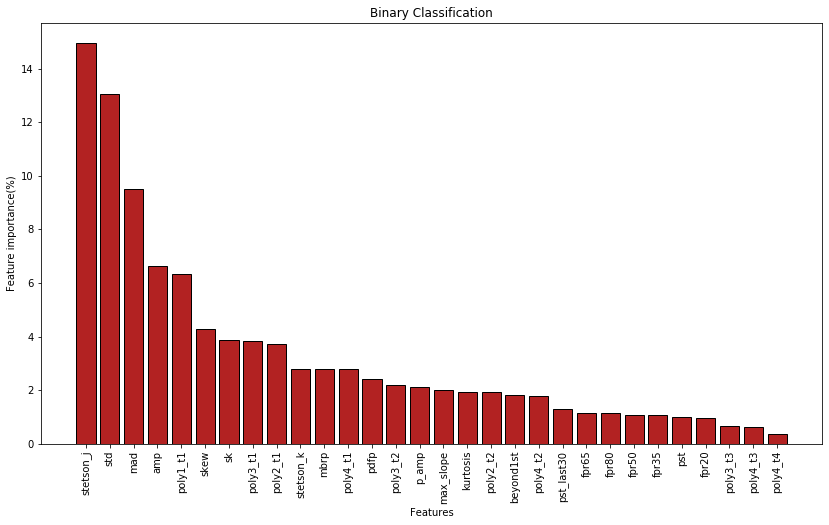

In [36]:


plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(14,8))
plt.gcf().subplots_adjust(bottom=0.15)
plt.bar(np.arange(len(y_sorted)), y_sorted,edgecolor='black',color='firebrick')
plt.xticks(np.arange(len(y_sorted)), x_sorted,rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Feature importance(%)')
plt.title("Binary Classification")
plt.savefig("../results/binFeatImportance.pdf")

In [37]:
cm = confusion_matrix(all_test.target, clf.predict(all_test[feats])).transpose()
cm

array([[3599,   69],
       [ 199,  254]])

In [49]:
np.save('./NatureResults/SNNTtargets.npy',np.array(all_test.target))

In [48]:
np.save('./NatureResults/SNNTprobs.npy',clf.predict_proba(all_test[feats]))

In [50]:
def fMeasure(precision,recall):
    return 2*precision*recall/(precision+recall)

In [51]:
precisionNon = cm[0][0]/(cm[0][0]+cm[0][1])
recallNon = cm[0][0]/(cm[0][0]+cm[1][0])
precisionT = cm[1][1]/(cm[1][1]+cm[1][0])
recallT = cm[1][1]/(cm[1][1]+cm[0][1])

In [52]:
print("Precision of transients:     {:.4f}".format(precisionT))
print("Recall of transients:        {:.4f}".format(recallT))
print("F-measure of transients:     {:.4f}".format(fMeasure(precisionT,recallT)))
print("Precision of non-transients: {:.4f}".format(precisionNon))
print("Recall of non-transients:    {:.4f}".format(recallNon))
print("F-measure of non-transients: {:.4f}".format(fMeasure(precisionNon,recallNon)))


Precision of transients:     0.5607
Recall of transients:        0.7864
F-measure of transients:     0.6546
Precision of non-transients: 0.9812
Recall of non-transients:    0.9476
F-measure of non-transients: 0.9641


# 5-Class clasification:
- BZ y 
- AGN y
- CV y
- SN y
- OTHER y 
- Non-T

In [53]:
tran.Class.unique()

array(['SN?', 'Var?', 'SN', 'CV', 'Blazar', 'AGN?', 'AGN', 'Flare', 'Var',
       'Flare?', 'Blazar?', 'SN/CV', 'SN/AGN', 'O/Ne', 'Carbon',
       'Unknown', 'Var/AGN', 'CV/Var', 'OH-IR', 'YSO', 'Mira', 'Variable',
       'HPM', 'YSO?', 'LPV', 'Var/nothing?', 'SDSS', 'QSO', 'CV?',
       'SN/TDE', 'AGN/Var', 'Blazar/AGN', 'Red', 'Merger/CV?', 'CV/SN',
       'Carb', 'Nova', 'SN/AGN?', 'Var/SN?', 'Ast', 'SN/Ast?', 'Ast?',
       'SN/Var', 'AGN/Blazar', 'Var/Ast', 'AGN/SN?', 'Ast/Flare?',
       'Comet', 'Lensing/nothing?', 'Ast/CV?', 'HPM?', 'Flare/SN', 'FU',
       'AGN/SN', 'Maser', 'UvES', 'RCorB', 'SN/Var?', 'CV/AGN?',
       'AGN/Var?', 'Comet/Ast?', 'CV/Flare', 'Ast/SN', 'CV/Var/Ast',
       'AGN/nothing?', 'SN/Ast', 'TDE?', 'GRB', 'SN/CV?', 'AGN/Flare?',
       'Var/SN', 'Blazar/SN', 'LHS_5157', 'Very', 'CV/AGN', 'AGN/CV',
       'RRL', 'AGB', 'Var/Ast?', 'Var/Nova', 'Ast/Var?', 'Ast/Var',
       'CV/Var?', 'Var/Nothing', 'OH_IR', 'SN/nothing?', 'RRLyrae',
       'HPM/Var?', 'Ast

In [55]:
# main 6 transient classes
labels = ['SN', 'CV', 'AGN', 'Blazar']

#copy transient data
tran5 = tran.copy()

#if class is not in labels, label as other
tran5.loc[~tran5.Class.isin(labels), ['Class']] = 'Other'

#copy non transient
ntran5 = ntran.copy()

#transients and non-transients
all5 = pd.concat([tran5,ntran5])

In [57]:
all5.Class.unique()

array(['Other', 'SN', 'CV', 'Blazar', 'AGN', 'non-transient'],
      dtype=object)

In [58]:
# func to map labels to integer values
def manualFact(lab):
    labels = ['SN', 'CV', 'AGN', 'Blazar','Other','non-transient']
    return labels.index(lab)

In [59]:
# map labels to integer values
all5['target'] = list(map(lambda x: manualFact(x),all5['Class']))

# copy labeled data
oversampling = all5.copy()

#shuffle data
oversampling = oversampling.sample(frac=1)

In [60]:
recall_scores = []

#split train test class by class
all_train,all_test = splitTrainTest(oversampling)

#balance the train set
all_train= balance(all_train)



#train indices
trainIdx = all_train.index.get_level_values("ID").unique()

#remove originals that may have oversampled copies in train
all_test = all_test[~all_test.index.get_level_values("ID").isin(trainIdx)]

#remove oversampling in test
all_test = all_test[all_test.index.get_level_values('copy_num')==0]


#format stuff
all_train.target= all_train.target.astype('int')
all_test.target= all_test.target.astype('int')

In [61]:
feats

array(['skew', 'std', 'kurtosis', 'beyond1st', 'stetson_j', 'stetson_k',
       'max_slope', 'amplitude', 'median_absolute_deviation',
       'median_buffer_range_percentage', 'pair_slope_trend',
       'percent_amplitude', 'percent_difference_flux_percentile',
       'flux_percentile_ratio_mid20', 'flux_percentile_ratio_mid35',
       'flux_percentile_ratio_mid50', 'flux_percentile_ratio_mid65',
       'flux_percentile_ratio_mid80', 'small_kurtosis',
       'pair_slope_trend_last_30', 'poly1_t1', 'poly2_t2', 'poly2_t1',
       'poly3_t3', 'poly3_t2', 'poly3_t1', 'poly4_t4', 'poly4_t3',
       'poly4_t2', 'poly4_t1'], dtype=object)

In [62]:
model,params = rf()
grid_search = GridSearchCV(model, params, cv=StratifiedKFold(2), scoring=scorers(),
                           refit='f1_score', return_train_score=True,verbose=100)
grid_search.fit(all_train[feats], all_train.target)
# Copy classifier
clf = grid_search

scores = precision_recall_fscore_support(
        all_test.target, clf.predict(all_test[feats]), average='weighted')


recall_scores.append(scores)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=(train=1.000, test=0.775), f1_score=(train=1.000, test=0.770), precision=(train=1.000, test=0.772), recall=(train=1.000, test=0.775), total=   4.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=(train=1.000, test=0.769), f1_score=(train=1.000, test=0.766), precision=(train=1.000, test=0.767), recall=(train=1.000, test=0.769), total=   4.6s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.4s remaining:    0.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV]  max_features=auto, n_estimators=700, accuracy=(train=1.000, test=0.774), f1_scor

In [63]:
recall_scoresnp = np.array(recall_scores)

print("Precision: {:.4f}".format(np.mean(recall_scoresnp[:,0])))
print("Recall:    {:.4f}".format(np.mean(recall_scoresnp[:,1])))
print("F-score:   {:.4f}".format(np.mean(recall_scoresnp[:,2])))

Precision: 0.8457
Recall:    0.8205
F-score:   0.8308


In [65]:
confMatr = confusion_matrix(all_test.target, clf.predict(all_test[feats])).transpose()
print(confMatr)
# 'SN', 'CV', 'AGN', 'Blazar','Other','non-transient'

[[ 180   23    0    8   44  125]
 [  28  152    1    7   19   39]
 [   2    2   81    8   34   35]
 [  15   14    5   36   18   10]
 [  42   16    3    0  159  206]
 [  56    8   16    0   89 3383]]


In [66]:
normedMatrix = confMatr.copy()
# print(normedMatrix)
for i in range(len(normedMatrix)):
#     print(normedMatrix[:,i]/normedMatrix[:,i].sum())
    normedMatrix[:,i] = normedMatrix[:,i]/normedMatrix[:,i].sum()
#     print(normedMatrix[:,i])
# np.set_printoptions(suppress=True)
print(normedMatrix)
# np.set_printoptions(suppress=False)

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [67]:
newMatr = []
for i in range(len(confMatr)):
    prec = confMatr[i][i]/(sum(confMatr[i,:]))
    rec = confMatr[i][i]/(sum(confMatr[:,i]))
    newMatr.append([prec,rec,fMeasure(prec,rec),sum(confMatr[:,i])])

In [68]:
np.set_printoptions(suppress=True)
print('    Precision        Recall         F-score      Cover')
print(np.array(newMatr))
np.set_printoptions(suppress=False)

    Precision        Recall         F-score      Cover
[[   0.47368421    0.55727554    0.51209104  323.        ]
 [   0.61788618    0.70697674    0.65943601  215.        ]
 [   0.5           0.76415094    0.60447761  106.        ]
 [   0.36734694    0.61016949    0.45859873   59.        ]
 [   0.37323944    0.43801653    0.40304183  363.        ]
 [   0.95242117    0.89073196    0.92054422 3798.        ]]


In [45]:
importances = clf.best_estimator_.feature_importances_*100
featsCopy = feats.copy()

Y = list(importances)
X = list(featsCopy)

yx = list(zip(Y, X))

yx.sort()
# yx = yx[::-1]
yx = yx[::-1]



x_sorted = [x for y, x in yx]
y_sorted = [y for y, x in yx]


In [47]:
for i,x in enumerate(x_sorted):
    x_sorted[i]=shorten(x)

/home/mauro/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


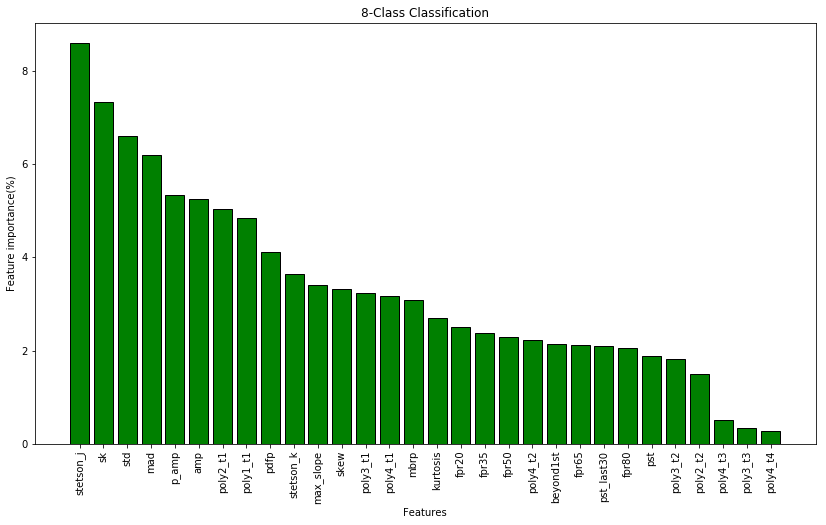

In [51]:
# from matplotlib.font_manager import FontProperties
# font = FontProperties()
# font.set_family('sans-serif')
# font.set_style('normal')

plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(14,8))
plt.gcf().subplots_adjust(bottom=0.15)
plt.bar(np.arange(len(y_sorted)), y_sorted,edgecolor='black',color='#008000')
plt.xticks(np.arange(len(y_sorted)), x_sorted,rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Feature importance(%)')
plt.title("8-Class Classification")
plt.savefig("8clasFeatImportance.pdf")